In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import feature_selection as fs
from sklearn import linear_model
import sklearn.metrics as sklm
from datetime import date

%matplotlib inline

In [ ]:
#import
#scale
#reduce features
#seperate intro train/test

In [67]:
def calc_age(birthday):
    today = date(1998, 1, 1)
    birthday = list(map(int, birthday.split('-')))
    born = date(birthday[0], birthday[1], birthday[2])
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def import_clean():
    # imports features and labels
    import_features = pd.read_csv('AdvWorksCusts.csv')
    import_labels = pd.read_csv('AW_BikeBuyer.csv')
    import_features = import_features.drop_duplicates(subset='CustomerID')
    import_labels = import_labels.drop_duplicates(subset='CustomerID')

    temp = import_features.merge(import_labels, how='left', on='CustomerID')
    temp['Age'] = [calc_age(birthday) for birthday in temp['BirthDate']]

    cat_cols = ['Education', 'Occupation', 'Gender', 'MaritalStatus', 'CountryRegionName']
    num_cols = ['Age', 'YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome', 'NumberCarsOwned']
    cat_already_encoded = ['HomeOwnerFlag']
    
    Labels = np.array(temp['BikeBuyer'])
    # Features has 15 categorical features, that have been one hot encoded
    Features = encode_string(temp[cat_cols])
    Features = np.concatenate([Features, np.array(temp[cat_already_encoded])], axis=1)
    num_cat = Features.shape[1]
    # concatenate numeric features
    Features = np.concatenate([Features, np.array(temp[num_cols])], axis=1)
    return Features, Labels, num_cat

def encode_string(cat_features):
    ohe = preprocessing.OneHotEncoder(categories = 'auto')
    encoded = ohe.fit(cat_features)
    return encoded.transform(cat_features).toarray()

# create training, test sets
def create_sets(Features, Labels):
    nr.seed(9988)
    indx = range(Features.shape[0])
    indx = ms.train_test_split(indx, test_size = .3)
    X_train = Features[indx[0],:]
    y_train = np.ravel(Labels[indx[0]])
    X_test = Features[indx[1],:]
    y_test = np.ravel(Labels[indx[1]])
    return X_train, y_train, X_test, y_test

def scale(features, num_cat):
    scaler = preprocessing.StandardScaler().fit(features[:, num_cat:])
    features[:,num_cat:] = scaler.transform(features[:, num_cat:])
    return features, scaler

def reduce(Features):
    sel = fs.VarianceThreshold(threshold=(.8 * (1 - .8)))
    Features_reduced = sel.fit_transform(Features)
    print(sel.get_support())
    print(Features_reduced.shape)
    print(Features_reduced[0])
    return Features_reduced

Features, Labels, num_cat = import_clean()
Features, scaler = scale(Features, num_cat)
#Features = reduce(Features)
X_train, y_train, X_test, y_test = create_sets(Features, Labels)
#X_train, X_test = scale(X_train,X_test, )

## Feature Selection

In [50]:
nr.seed(123)
inside = ms.KFold(n_splits=10, shuffle = True)
nr.seed(321)
outside = ms.KFold(n_splits=10, shuffle = True)

nr.seed(3456)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"C": [0.1, 1, 10, 100, 1000]}
## Define the logistic regression model
logistic_mod = linear_model.LogisticRegression(class_weight = {0:0.4, 1:0.6}, solver='liblinear') 

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = logistic_mod, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'roc_auc',
                      return_train_score = True)

## Fit the cross validated grid search over the data 
clf.fit(Features, Labels)

## And print the best parameter value
clf.best_estimator_.C

0.1

In [54]:
nr.seed(498)
cv_estimate = ms.cross_val_score(clf, Features, Labels, 
                                 cv = outside) # Use the outside folds
print('Mean performance metric = %4.3f' % np.mean(cv_estimate))

print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

Mean performance metric = 0.835
SDT of the metric       = 0.010
Outcomes by cv fold
Fold  1    0.835
Fold  2    0.827
Fold  3    0.840
Fold  4    0.840
Fold  5    0.837
Fold  6    0.839
Fold  7    0.818
Fold  8    0.822
Fold  9    0.851
Fold 10    0.843


In [51]:
logistic_mod = linear_model.LogisticRegression(solver='liblinear', class_weight = {0:0.4, 1:0.6}, C = clf.best_estimator_.C) 
logistic_mod.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight={0: 0.4, 1: 0.6}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
probabilities = logistic_mod.predict_proba(X_test)
#print(probabilities[:15,:])

def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])
scores = score_model(probabilities, 0.5)
#print(np.array(scores[:15]))
#print(y_test[:15])

def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])


    
print_metrics(y_test, scores) 

                 Confusion matrix
                 Score positive    Score negative
Actual positive      2776               493
Actual negative       583              1070

Accuracy  0.78
 
           Positive      Negative
Num case     3269          1653
Precision    0.83          0.68
Recall       0.85          0.65
F1           0.84          0.67


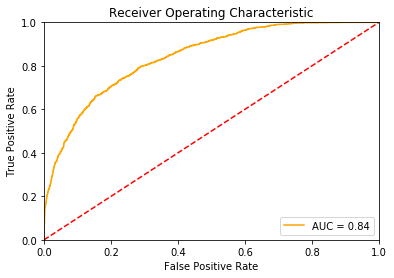

In [53]:
def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_auc(y_test, probabilities)   

In [71]:
def calc_age_test(birthday):
    today = date(1998, 1, 1)
    birthday = list(map(int, birthday.split('/')))
    born = date(birthday[2], birthday[0], birthday[1])
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

test = pd.read_csv('AW_test.csv')
test['Age'] = [calc_age_test(birthday) for birthday in test['BirthDate']]

cat_cols = ['Education', 'Occupation', 'Gender', 'MaritalStatus', 'CountryRegionName']
num_cols = ['Age', 'YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome', 'NumberCarsOwned']
cat_already_encoded = ['HomeOwnerFlag']

Features = encode_string(test[cat_cols])
Features = np.concatenate([Features, np.array(test[cat_already_encoded])], axis=1)
print(Features.shape)
Features = np.concatenate([Features, np.array(test[num_cols])], axis=1)
print(Features.shape)
Features[:,21:] = scaler.transform(Features[:,21:])

probabilities = logistic_mod.predict_proba(Features)

scores = score_model(probabilities, .5)

(500, 21)
(500, 26)


In [75]:
test_out = pd.DataFrame(scores)

In [77]:
test_out.to_csv('test1.csv')